In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import tv_tensors
import torch
from torch import nn
from torchvision.transforms import v2

import project.utils
%reload project
from project.config import PROJECT_ROOT

In [2]:
from project.data.cvc_clinic import ClinicDB

transforms = v2.Compose([
    v2.ToImage(),
    v2.RandomPhotometricDistort(p=1),
    # v2.RandomZoomOut(),
    # v2.RandomIoUCrop(),
    v2.RandomHorizontalFlip(p=1),
    # v2.SanitizeBoundingBoxes(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transforms

Compose(
      ToImage()
      RandomPhotometricDistort(brightness=(0.875, 1.125), contrast=(0.5, 1.5), hue=(-0.05, 0.05), saturation=(0.5, 1.5), p=1)
      RandomHorizontalFlip(p=1)
      ToDtype(scale=True)
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [3]:
dataset = ClinicDB(PROJECT_ROOT / "data", split="train", transforms=transforms)
dataset.data.shape, dataset[0][0].shape

((428, 3, 288, 384), torch.Size([3, 288, 384]))

In [4]:
train_loader = dataset.get_loader(batch_size=5, shuffle=True)
train_loader

torch.Size([1, 3, 288, 384])
<class 'torch.Tensor'> <class 'dict'>
torch.uint8


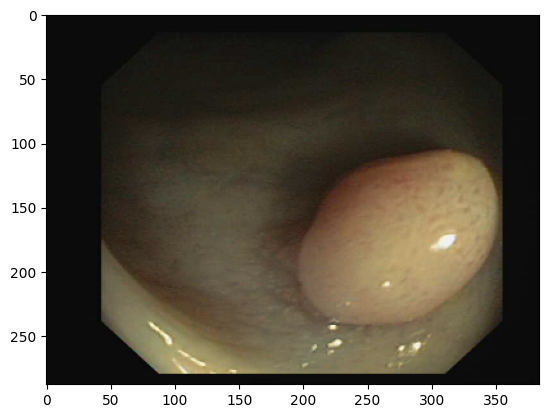

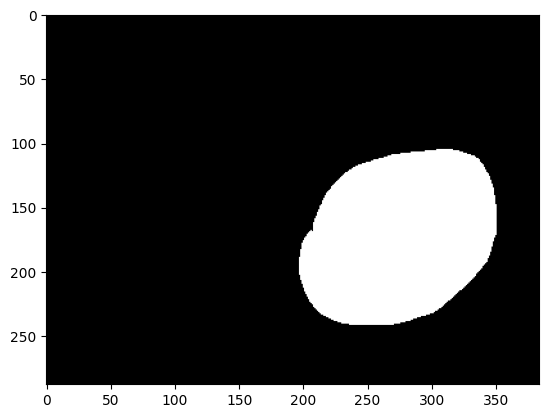

In [5]:
base_loader = ClinicDB(PROJECT_ROOT / "data", split="train", transforms=None).get_loader(batch_size=1, shuffle=True)
for i, (data, target) in enumerate(base_loader):
    print(data.shape)
    print(type(data), type(target))
    print(data.dtype)
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    plt.imshow(target["masks"][0].numpy().transpose(1, 2, 0), cmap="gray")
    plt.show()
    break

In [13]:
# Intersection over Union (IoU) loss
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets):
        # Sigmoid activation
        inputs = torch.sigmoid(inputs)
        
        # Flattening
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Intersection
        intersection = (inputs * targets).sum()
        
        # Union
        total = (inputs + targets).sum()
        
        # IoU
        IoU = (intersection + 1e-8) / (total - intersection + 1e-8)
        
        return (1 - IoU) * 100  # Scale to 0-100 to make it more interpretable

In [20]:
%reload project
from project.models.unet import UNet
from project.models.vnet.vnet import BinaryDiceLoss

torch.cuda.empty_cache()
model = UNet(n_channels=3, n_classes=1).to("cuda")
# criterion = IoULoss()
criterion = BinaryDiceLoss()
optimizer = torch.optim.Adam(model.parameters())

In [21]:
for epoch in range(100):
    model.train()
    for i, (data, target) in enumerate(train_loader):
        mask = target["masks"]
        data, mask = data.to("cuda"), mask.to("cuda")
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        
        if i % 20 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item()}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 136.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 5.16 GiB is allocated by PyTorch, and 113.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model.eval()
test_set = ClinicDB(dataset_root, split="test", transforms=transforms)
test_loader = test_set.get_loader(batch_size=1, shuffle=True)

for i, (data, target) in enumerate(test_loader):
    data, target = data.to("cuda"), target.to("cuda")
    output = model(data)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(data[0].cpu().numpy().transpose(1, 2, 0))
    plt.title("Input")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    
    # Sigmoid activation
    output = torch.sigmoid(output)
    output = (output > 0.5).float()
    
    plt.imshow(output[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap="gray")
    plt.title("Output")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(target[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap="gray")
    plt.title("Target")
    plt.axis("off")
    
    plt.show()
    
    if i == 5:
        break
    

In [ ]:
from project.config import PROJECT_ROOT

save_path = PROJECT_ROOT / "models" / "clinicdb_unet.pth"
torch.save({
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "epoch": epoch
}, save_path)